In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
import pickle
import warnings
import statsmodels.api as sm
from scipy.interpolate import UnivariateSpline
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import grangercausalitytests
warnings.filterwarnings('ignore')


In [2]:
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/nyt_ts_df.csv')
ts_df = ts_df.groupby(['words','year','property','count']).outputs_z.mean().reset_index()


In [3]:
#reference: https://www.bls.gov/cpi/factsheets/average-prices.htm

cpi = pd.read_csv('./data/cpi.csv') #contains product names
cpi2 = pd.read_csv('./data/cpi2.csv') #monthy prices

In [4]:
len(cpi2)

160

In [5]:
cpi = cpi2.set_index('Series ID').\
join(cpi.set_index('Series ID')['Item']).reset_index()

In [9]:
item_category = {
    'Ice cream':'ice cream',
    'Malt beverages': 'beer',
    'All uncooked ground beef':'beef',
    'All Uncooked Beef Roasts':'beef',
    'All Uncooked Beef Steaks':'steak',
    'All Uncooked Other Beef (Excluding Veal)':'other beef',
    'All Ham (Excluding Canned Ham and Luncheon Slices)':'ham',
    'All Pork Chops':'pork',
    'All Other Pork (Excluding Canned Ham and Luncheon Slices)':'pork',
    'Automotive diesel fuel':'diesel',
    'Cucumbers':'cucumber',
    'Peaches':'peach',
    'Potato chips':'chips',
    'Electricity per KWH': 'electricity',
    'Cookies':'cookie',
    'Ground chuck':'beef',
    'Ground beef':'beef',
    'Chuck roast':'beef',
    'Round roast':'beef',
    'Rib roast':'beef',
    'Steak':'steak',
    'Chops':'pork',
    'Pork sirloin roast':'pork',
    'Shoulder picnic':'pork',
    'Lamb and mutton':'lamb',
    'Chicken breast':'chicken',
    'Chicken legs':'chicken',
    'Eggs':'egg',
    'American processed cheese':'cheese',
    'Cheddar cheese':'cheese',
    'Apples':'apple',
    'Bananas':'banana',
    'Oranges':'orange',
    'Lemons':'lemon',
    'Pears':'pear',
    'Strawberries':'strawberry',
    'Grapes':'grape',
    'Cherries':'cherry',
    'Potatoes':'potatoe',
    'Tomatoes':'tomatoe',
    'Carrots':'carrot',
    'Onions':'onion',
    'Radishes':'radish',
    'Peppers':'pepper',
    'Corn on the cob':'corn',
    'Beans':'bean',
}

In [10]:
cpi = cpi.dropna()

In [11]:
cpi['words'] = cpi.Item.apply(lambda x : x.split(',')[0] )
cpi['words'] = cpi.words.apply(lambda x : x.lower() if x not in item_category else item_category[x])


In [12]:
items = cpi.words.unique()

In [13]:
ts_df = ts_df.loc[ts_df.words.isin(items)].reset_index(drop = True)

In [14]:

cpi = pd.melt(cpi, id_vars = ['Item','words','Series ID'])


In [15]:
cpi['year'] = cpi.variable.apply(lambda x : int(x.split(' ')[1]))
cpi.year.unique()

array([1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007])

In [16]:
cpi.value = cpi.value.apply(lambda x : float(x) if len(x.strip()) > 0 else None)

In [17]:
cpi = cpi.dropna().reset_index(drop = True)

In [18]:
cpi = cpi.groupby(['Item','words','Series ID','year','variable']).value.mean().reset_index()

In [19]:
df2 = cpi.copy(deep = True)
df2.variable = df2.variable.apply(lambda x : x.split()[0] + ' ' + str(int(x.split()[1]) + 1))
df2.year = df2.year + 1
cpi = cpi.set_index(['Item','words','Series ID','year','variable']).join(\
df2.set_index(['Item','words','Series ID','year','variable']), lsuffix = '_2',rsuffix = '_1').reset_index()

In [20]:
cpi.sample(2)

,Item,words,Series ID,year,variable,value_2,value_1
14856,"Potatoes, white, per lb. (453.6 gm)",potatoe,APU0000712112,2001,Jan 2001,0.355,0.392
20026,Utility (piped) gas per therm,utility (piped) gas per therm,APU000072620,1997,Feb 1997,0.730,0.637


In [21]:

cpi = cpi.groupby(['Item','words','Series ID','year'])[['value_1','value_2']].mean().reset_index().dropna()


In [22]:
cpi['value_change'] = cpi.value_2 / cpi.value_1 - 1 #relative price change between two consequtive years

In [23]:
cpi.loc[cpi.words =='beef'].Item.unique()

array(['All Uncooked Beef Roasts, per lb. (453.6 gm)',
       'All uncooked ground beef, per lb. (453.6 gm)',
       'Chuck roast, USDA Choice, bone-in, per lb. (453.6 gm)',
       'Chuck roast, USDA Choice, boneless, per lb. (453.6 gm)',
       'Chuck roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm)',
       'Ground beef, 100% beef, per lb. (453.6 gm)',
       'Ground beef, lean and extra lean, per lb. (453.6 gm)',
       'Ground chuck, 100% beef, per lb. (453.6 gm)',
       'Rib roast, USDA Choice, bone-in, per lb. (453.6 gm)',
       'Round roast, USDA Choice, boneless, per lb. (453.6 gm)',
       'Round roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm)'],
      dtype=object)

In [24]:
new_df = ts_df.copy(deep = True)
new_df['year'] = new_df.year + 1
change_df = ts_df.set_index(['words','year','property']).\
join(new_df.set_index(['words','year','property']), lsuffix = '_2',rsuffix = '_1').reset_index()
change_df

,words,year,property,count_2,outputs_z_2,count_1,outputs_z_1
0,apple,1987,polarity,2539.0,0.123073,NaN,NaN
1,apple,1987,previous_link,2539.0,-1.376371,NaN,NaN
2,apple,1988,polarity,2557.0,0.111513,2539.0,0.123073
3,apple,1988,previous_link,2557.0,-1.357751,2539.0,-1.376371
4,apple,1989,polarity,3056.0,0.109784,2557.0,0.111513
...,...,...,...,...,...,...,...
2185,yogurt,2005,previous_link,269.0,0.082218,225.0,0.112264
2186,yogurt,2006,polarity,328.0,0.404199,269.0,0.375797
2187,yogurt,2006,previous_link,328.0,0.124624,269.0,0.082218
2188,yogurt,2007,polarity,232.0,0.425429,328.0,0.404199


In [25]:
joint_df = change_df.set_index(['words','year']).\
join(cpi.set_index(['words','year'])).dropna().reset_index()

In [26]:

joint_df['moral_change'] = joint_df['outputs_z_2'] - joint_df['outputs_z_1']

In [27]:
r_df = joint_df.loc[joint_df.property == 'previous_link']
p_df = joint_df.loc[joint_df.property == 'polarity']
final_df = r_df.set_index(['words','year','Item','Series ID','value_change','value_1','value_2','count_2','count_1']).join(\
p_df.set_index(['words','year','Item','Series ID','value_change','value_1','value_2','count_2','count_1']), lsuffix = '_relevance',
    rsuffix = '_polarity').reset_index()
final_df.sample(2)

,words,year,Item,Series ID,value_change,value_1,value_2,count_2,count_1,property_relevance,outputs_z_2_relevance,outputs_z_1_relevance,moral_change_relevance,property_polarity,outputs_z_2_polarity,outputs_z_1_polarity,moral_change_polarity
35,bacon,2003,"Bacon, sliced, per lb. (453.6 gm)",APU0000704111,-0.011820,3.236167,3.197917,633.0,710.0,previous_link,-0.500130,-0.481238,-0.018892,polarity,0.481792,0.499778,-0.017986
148,beef,1997,"Round roast, graded and ungraded, excluding US...",APU0000703312,0.006252,2.665833,2.682500,1232.0,1576.0,previous_link,0.507361,0.428435,0.078926,polarity,0.357434,0.262645,0.094790


In [28]:
plot_df = final_df.loc[(final_df.moral_change_relevance > 0)] #Keeping morally relevant products only
len(plot_df), len(final_df)

(704, 1361)

In [29]:
", ".join(plot_df.words.unique())

'apple, bacon, banana, bean, beef, beer, bologna, bread, broccoli, butter, cabbage, carrot, celery, cheese, cherry, chicken, coffee, cola, cookie, corn, cucumber, diesel, egg, electricity, flour, gasoline, grape, grapefruit, ham, ice cream, lamb, lemon, lettuce, margarine, milk, onion, orange, orange juice, peach, peanut butter, pear, pepper, pork, rice, sausage, steak, strawberry, sugar, tuna, turkey, vodka, wine, yogurt'

In [30]:
final_df.groupby(['words','year'])['moral_change_relevance'].mean().reset_index().\
sort_values(by = 'moral_change_relevance', ascending = False).head(50)

,words,year,moral_change_relevance
761,strawberry,1995,0.676165
111,bologna,1996,0.470681
764,strawberry,1998,0.409457
278,cola,1996,0.303732
108,bologna,1990,0.293182
760,strawberry,1994,0.286988
119,bologna,2004,0.270654
328,diesel,2002,0.251857
756,strawberry,1990,0.192930
819,turkey,1995,0.175996


In [31]:
plot_df_2 = plot_df.groupby(['words','year'])[['value_change','value_1','moral_change_relevance','moral_change_polarity']].mean().reset_index()

In [32]:
spearmanr(plot_df_2.moral_change_polarity,plot_df_2.value_change)

SignificanceResult(statistic=-0.1320313919728173, pvalue=0.005540771724575582)

In [33]:
spearmanr(plot_df.moral_change_polarity,plot_df.value_change)

SignificanceResult(statistic=-0.15399103839953263, pvalue=4.0768446484118855e-05)

In [36]:
from adjustText import adjust_text


In [37]:
labels1 = plot_df.loc[plot_df.moral_change_polarity > 0.1].sample(1)
labels2 = plot_df.loc[plot_df.moral_change_polarity < -0.2].sample(2)
labels3 = plot_df.loc[plot_df.value_change < 0].sample(1)
labels4 = plot_df.loc[plot_df.value_change > 0.3].sample(1)
labels5 = plot_df.sample(2)
labels = pd.concat((labels1,labels2,labels3,labels4,labels5))
labels = labels.loc[~labels.words.isin(['orange'])]
labels = labels.groupby('words').sample(1)
labels = pd.DataFrame()

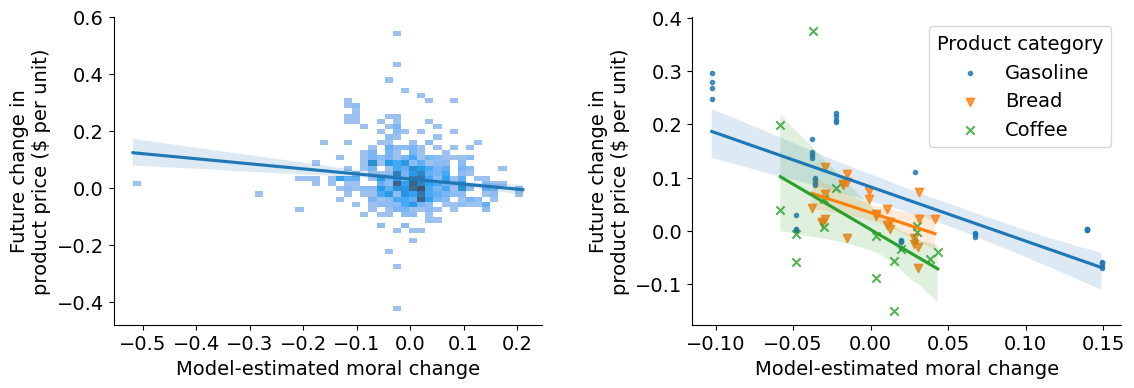

In [38]:


fig, axes = plt.subplots(1,2, figsize = (13, 4),sharex = False, sharey = False)
ax = axes[0]
# ax.set_xlim(-0.3,0.25)
plt.subplots_adjust( wspace=0.35)


sns.histplot(data = plot_df,
             x = 'moral_change_polarity', y = 'value_change' ,ax= ax,
               
               )

sns.regplot(data = plot_df,
             x = 'moral_change_polarity', y = 'value_change' ,ax = ax,scatter = False)
ax.set_ylabel('Future change in\nproduct price ($ per unit)',fontsize = 14)
ax.set_xlabel('Model-estimated moral change',fontsize = 14)
r,p = pearsonr(plot_df.moral_change_polarity,plot_df.value_change)
# ax.set_title(f'Pearson\'s r = {round(r, 3)}***, n = {len(plot_df)}')
for i, row in labels.iterrows():
    ax.text(x = row['moral_change_polarity'],
            y = row['value_change'],
            # s = row['Item'][:15] + '...\n' +' ('+ str(row['year'] - 1) + '-' + str(row['year']) + ')',
            s = row['Item'].split(',')[0][:10],
            fontsize = 13,
            color = 'black'
           )
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

ax = axes[1]
words = ['gasoline','bread','coffee']
sns.regplot(data = plot_df.loc[plot_df.words ==words[0]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:blue',
            marker = '.',
               label = 'Gasoline' ,
             ax = ax,
           )


sns.regplot(data = plot_df.loc[plot_df.words ==words[1]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:orange',
           label = 'Bread' ,
            marker = 'v',
             ax = ax)
sns.regplot(data = plot_df.loc[plot_df.words ==words[2]],
             x = 'moral_change_polarity',
             y = 'value_change',
             color = 'tab:green',
            marker = 'x',
           label = 'Coffee' ,
             ax = ax)
ax.set_ylabel('Future change in\nproduct price ($ per unit)',fontsize = 14)
ax.set_xlabel('Model-estimated moral change',fontsize = 14)
ax.legend(title = 'Product category',fontsize = 14,title_fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize = 14)
ax.set_yticklabels(ax.get_yticklabels(),fontsize = 14)

sns.despine()
# plt.savefig('notebooks/figs/nyt_cpi.png',dpi = 500, bbox_inches = 'tight')
# plt.savefig('notebooks/figs/nyt_cpi.pdf',dpi = 500, bbox_inches = 'tight')
plt.show()

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error


In [40]:
category_counts = plot_df.groupby('Item').year.count().to_dict()
mixed_df = plot_df.copy(deep = True)

mixed_df['category_count'] = mixed_df.Item.apply(lambda c : category_counts[c])
mixed_df = mixed_df.loc[mixed_df['category_count'] >= 10]


In [41]:
len(mixed_df.Item.unique())

33

In [42]:
#normalization
mixed_df['value_1'] = (mixed_df['value_1'] -  mixed_df['value_1'].mean()) / mixed_df['value_1'].std()
mixed_df['value_2'] = (mixed_df['value_2'] -  mixed_df['value_2'].mean()) / mixed_df['value_2'].std()
mixed_df['value_change'] = (mixed_df['value_change'] -  mixed_df['value_change'].mean()) / mixed_df['value_change'].std()
mixed_df['moral_change_polarity'] = (mixed_df['moral_change_polarity'] -  mixed_df['moral_change_polarity'].mean()) / mixed_df['moral_change_polarity'].std()
mixed_df['year_norm'] = (mixed_df['year'] -  mixed_df['year'].mean()) / mixed_df['year'].std()


In [43]:
mixed_df.sample(2)

,words,year,Item,Series ID,value_change,value_1,value_2,count_2,count_1,property_relevance,outputs_z_2_relevance,outputs_z_1_relevance,moral_change_relevance,property_polarity,outputs_z_2_polarity,outputs_z_1_polarity,moral_change_polarity,category_count,year_norm
214,beef,2005,"Ground beef, 100% beef, per lb. (453.6 gm)",APU0000703112,0.428660,0.357412,0.440249,1316.0,1347.0,previous_link,0.605265,0.562647,0.042618,polarity,0.345762,0.344424,-0.043660,11,1.246603
15,apple,2003,"Apples, Red Delicious, per lb. (453.6 gm)",APU0000711111,0.079211,-0.763693,-0.756564,2174.0,1911.0,previous_link,-1.284778,-1.310445,0.025667,polarity,0.208992,0.170091,0.575205,13,0.892697


In [44]:
model1 = smf.ols("value_change ~ value_1 + C(Item) + year_norm", mixed_df).fit()  
r2 = r2_score(mixed_df.value_change,model1.predict(mixed_df))
print(r2)

print("Random effect:")
print('MSE:', mean_squared_error(mixed_df.value_change, model1.predict(mixed_df)))
print(model1.summary())

0.13957379690129113
Random effect:
MSE: 0.8580160456670601
                            OLS Regression Results                            
Dep. Variable:           value_change   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.536
Date:                Sat, 11 Jan 2025   Prob (F-statistic):             0.0323
Time:                        12:07:15   Log-Likelihood:                -479.23
No. Observations:                 357   AIC:                             1028.
Df Residuals:                     322   BIC:                             1164.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------

In [45]:
model2 = smf.ols("value_change ~ moral_change_polarity + year_norm + C(Item) + value_1", mixed_df).fit()  
r2 = r2_score(mixed_df.value_change,model2.predict(mixed_df))
print(r2)

print("Random effect:")
print('MSE:', mean_squared_error(mixed_df.value_change, model2.predict(mixed_df)))
print(model2.summary())

0.17128626443988437
Random effect:
MSE: 0.8263924085697514
                            OLS Regression Results                            
Dep. Variable:           value_change   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     1.896
Date:                Sat, 11 Jan 2025   Prob (F-statistic):            0.00234
Time:                        12:07:18   Log-Likelihood:                -472.52
No. Observations:                 357   AIC:                             1017.
Df Residuals:                     321   BIC:                             1157.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------

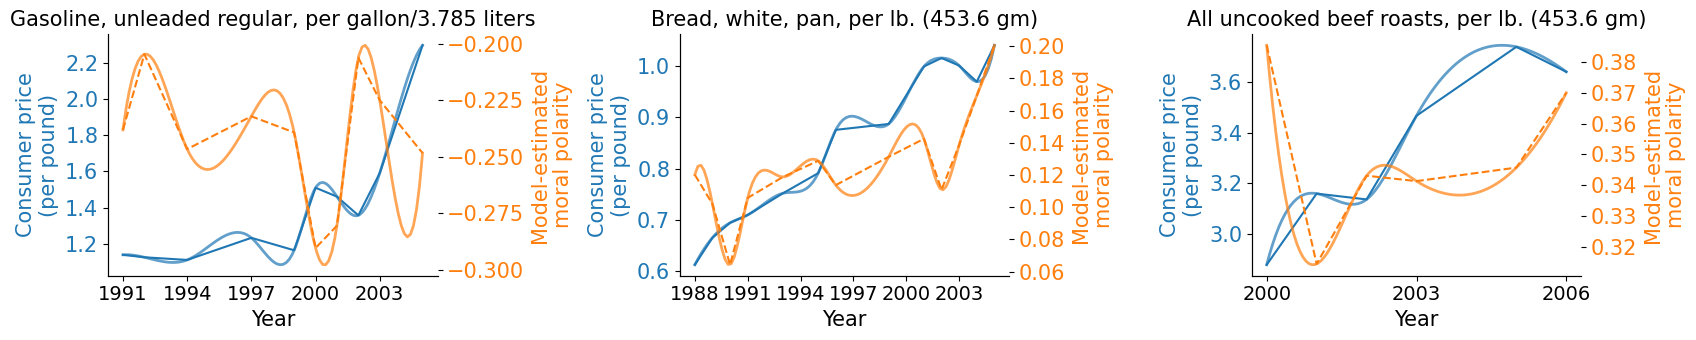

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import UnivariateSpline
import pandas as pd

items = ['Gasoline, unleaded regular, per gallon/3.785 liters','Bread, white, pan, per lb. (453.6 gm)','All Uncooked Beef Roasts, per lb. (453.6 gm)']
fig, axes = plt.subplots(1, len(items), figsize=(17, 3.5),sharey = False)

for i, w in enumerate(items):
    ax = axes[i]
    
    # Filter data for the word
    plotting_words = plot_df[plot_df.Item == w]
    
    # Primary y-axis: value_change
    sns.lineplot(data=plotting_words, x='year', y='value_2',
                 hue='words', errorbar=None, ax=ax, color='tab:blue')
    
    
    # Smooth line for value_change
    x = plotting_words.groupby('year').value_2.mean().reset_index().year
    y = plotting_words.groupby('year').value_2.mean().reset_index().value_2
    spl = UnivariateSpline(x, y, k=3, s=0)
    xs = np.linspace(x.min(), x.max(), 100)
    ax.plot(xs, spl(xs), 'tab:blue', lw=2, alpha=0.7)
    
    # Secondary y-axis: moral_change_polarity
    ax2 = ax.twinx()
    sns.lineplot(data=plotting_words, x='year', y='outputs_z_2_polarity',
                 linestyle='--', color='tab:orange', ax=ax2)
    
    
    # Smooth line for moral_change_polarity
    x = plotting_words.groupby('year').outputs_z_2_polarity.mean().reset_index().year
    y = plotting_words.groupby('year').outputs_z_2_polarity.mean().reset_index().outputs_z_2_polarity
    spl = UnivariateSpline(x, y, k=3, s=0)
    xs = np.linspace(x.min(), x.max(), 100)
    ax2.plot(xs, spl(xs), 'tab:orange', lw=2, alpha=0.7)
    
    # Add labels and titles
    ax.set_xlabel('Year', fontsize = 15)
    if i == 0:
        ax.set_ylabel('Consumer price\n(per pound)',color = 'tab:blue',fontsize = 15)
    else:
        ax.set_ylabel('Consumer price\n(per pound)',color = 'tab:blue',fontsize = 15)

    if i == 1:
        ax2.set_ylabel('Model-estimated\nmoral polarity',color ='tab:orange',fontsize = 15)
    else:
        ax2.set_ylabel('Model-estimated\nmoral polarity',color ='tab:orange',fontsize = 15)
    
    ax.set_title(w.capitalize(),fontsize = 15)
    
    # Adjust tick parameters and legends
    ax.set_xticks(np.arange(plotting_words.year.min(), plotting_words.year.max() + 1, 3))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 14)
    ax.set_yticklabels(ax.get_yticklabels(), color = 'tab:blue',fontsize = 15)
    
    ax2.set_xticks(np.arange(plotting_words.year.min(), plotting_words.year.max() + 1, 3))
    ax2.set_yticklabels(ax2.get_yticklabels(), color = 'tab:orange',fontsize = 15)
    ax2.set_xticklabels(ax2.get_xticklabels(), fontsize = 15)
    
    ax.legend_ = None
    sns.despine()
    # ax2.despine(right=True)

plt.tight_layout()
# plt.savefig('notebook/figs/nyt_cpi_timeseries.pdf',dpi = 500, bbox_inches = 'tight')
# plt.savefig('notebook/figs/nyt_cpi_timeseries.png',dpi = 500, bbox_inches = 'tight')
plt.show()


In [49]:
model2 = smf.mixedlm("value_change ~ value_1 + C(year)", mixed_df, groups= "words",
                     re_formula ="~1").fit()
r2 = r2_score(mixed_df.value_change,model2.predict(mixed_df))
print(r2)
print(model2.summary())
print("Random effect:")
print(model2.random_effects)

intercept = model2.params['Intercept']
var = model2.params["words Var"]
print(intercept, var)
print('MSE:', mean_squared_error(mixed_df.value_change, model2.predict(mixed_df)))

0.12991138577899874
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value_change
No. Observations: 357     Method:             REML        
No. Groups:       24      Scale:              0.9128      
Min. group size:  10      Log-Likelihood:     -494.2111   
Max. group size:  43      Converged:          Yes         
Mean group size:  14.9                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       -0.023    0.235 -0.098 0.922 -0.483  0.437
C(year)[T.1989]  0.165    0.362  0.455 0.649 -0.545  0.874
C(year)[T.1990]  0.045    0.354  0.126 0.900 -0.649  0.738
C(year)[T.1991] -0.090    0.304 -0.296 0.767 -0.685  0.506
C(year)[T.1992] -1.051    0.330 -3.185 0.001 -1.698 -0.404
C(year)[T.1993] -0.164    0.324 -0.504 0.614 -0.799  0.472
C(year)[T.1994]  0.154    0.375  0.409 0.682 -0

In [50]:
product_table = plot_df[['Item','words']].drop_duplicates()
print('Product & Simplified name \\\\')
for i, row in product_table.iterrows():
    print(row['Item'], '&', row['words'], '\\\\')

Product & Simplified name \\
Apples, Red Delicious, per lb. (453.6 gm) & apple \\
Bacon, sliced, per lb. (453.6 gm) & bacon \\
Bananas, per lb. (453.6 gm) & banana \\
Beans, dried, any type, all sizes, per lb. (453.6 gm) & bean \\
Chuck roast, USDA Choice, bone-in, per lb. (453.6 gm) & beef \\
Ground beef, 100% beef, per lb. (453.6 gm) & beef \\
Ground chuck, 100% beef, per lb. (453.6 gm) & beef \\
Rib roast, USDA Choice, bone-in, per lb. (453.6 gm) & beef \\
Round roast, USDA Choice, boneless, per lb. (453.6 gm) & beef \\
Chuck roast, USDA Choice, boneless, per lb. (453.6 gm) & beef \\
Chuck roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm) & beef \\
Ground beef, lean and extra lean, per lb. (453.6 gm) & beef \\
Round roast, graded and ungraded, excluding USDA Prime and Choice, per lb. (453.6 gm) & beef \\
All Uncooked Beef Roasts, per lb. (453.6 gm) & beef \\
All uncooked ground beef, per lb. (453.6 gm) & beef \\
Malt beverages, all types, all sizes, any